In [139]:
%matplotlib inline

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import functools
# -----------------------------------------------------------------------------
# Muon optimizer

def zeropower_via_svd(G, steps=None):
    U, S, V = G.svd()
    return U @ V.T

def zeropower_via_newtonschulz5(G, steps=10, eps=1e-7, dtype=torch.bfloat16,
                                abc: torch.Tensor = torch.tensor((3.4445, -4.7750,  2.0315)), normalize=True):
    r"""
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' \sim Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert len(G.shape) == 2
    if normalize:
        X = G.to(dtype) / (G.norm() + eps) # ensure top singular value <= 1
    else:
        X = G.to(dtype)
    abc = abc.expand(steps, 3).to(dtype)
    # a, b, c = abc
    if G.size(0) > G.size(1):
        X = X.T
    for a, b, c in zip(*abc.unbind(dim=1)):
        A = X @ X.T
        B = A @ X
        X = a * X + b * B + c * A @ B
    if G.size(0) > G.size(1):
        X = X.T
    return X.to(G.dtype)

zeropower_via_newtonschulz5 = functools.wraps(zeropower_via_newtonschulz5)(torch.compile(zeropower_via_newtonschulz5))

zeropower_backends = dict(svd=zeropower_via_svd, newtonschulz5=zeropower_via_newtonschulz5)

class Muon(torch.optim.Optimizer):
    r"""
    Muon - MomentUm Orthogonalized by Newton-schulz

    Muon internally runs standard SGD-momentum, and then performs an orthogonalization post-
    processing step, in which each 2D parameter's update is replaced with the nearest orthogonal
    matrix. To efficiently orthogonalize each update, we use a Newton-Schulz iteration, which has
    the advantage that it can be stably run in bfloat16 on the GPU.

    Some warnings:
    - This optimizer assumes that all parameters passed in are 2D.
    - It should not be used for the embedding layer, the final fully connected layer, or any {0,1}-D
    parameters; those should all be optimized by a standard method (e.g., AdamW).
    - To use it with 4D convolutional filters, it works well to just flatten their last 3 dimensions.
    - We believe it is unlikely to work well for training with small batch size.
    - We believe it may not work well for finetuning pretrained models, but we haven't tested this.
    - We have not yet tried this optimizer for training scenarios larger than NanoGPT (124M).

    Arguments:
        lr: The learning rate used by the internal SGD.
        momentum: The momentum used by the internal SGD.
        nesterov: Whether to use Nesterov-style momentum in the internal SGD. (recommended)
        backend: The chosen backend for the orthogonalization step. (recommended: 'newtonschulz5')
        backend_steps: The number of iteration steps to use in the backend, if it is iterative.
    """
    def __init__(self, params, lr=3e-4, momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5):
        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov, backend=backend, backend_steps=backend_steps)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            zeropower_backend = zeropower_backends[group['backend']]
            for p in group['params']:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(g)
                buf = state['momentum_buffer']
                buf.mul_(momentum).add_(g)
                if group['nesterov']:
                    g = g.add(buf, alpha=momentum)
                if g.size(0) == 3 * g.size(1): # split grouped QKV parameters; following @bozavlado's finding
                    g = torch.cat([zeropower_backend(g1, steps=group['backend_steps']) for g1 in g.split(g.size(1))])
                    scale = g.size(1)**0.5
                else:
                    g = zeropower_backend(g, steps=group['backend_steps'])
                    scale = max(g.size(0), g.size(1))**0.5 # scale to have update.square().mean() == 1
                p.data.add_(g, alpha=-lr * scale)

In [119]:
G = torch.randn(1024, 256) @ torch.randn(256, 1024) + 0.1 * torch.randn(1024, 1024)

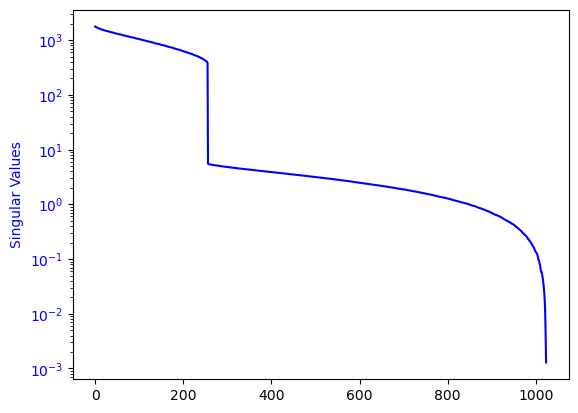

In [120]:
# Create twin axes
fig, ax1 = plt.subplots()

# Plot singular values on the left y-axis
ax1.plot(G.svd().S, color='blue')
ax1.set_ylabel('Singular Values', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.yscale('log')
plt.show()

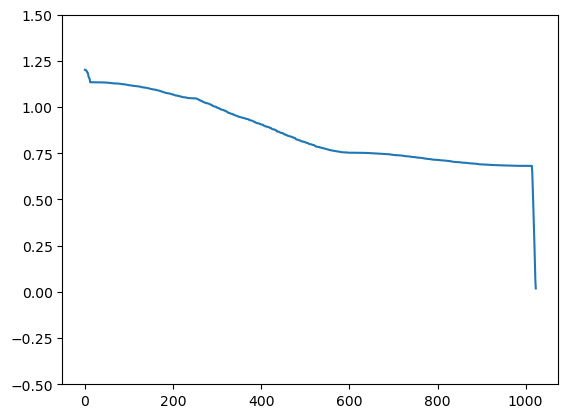

In [121]:
plt.plot(zeropower_via_newtonschulz5(G, dtype=torch.float32).svd().S)
plt.ylim(-0.5, 1.5)
plt.show()

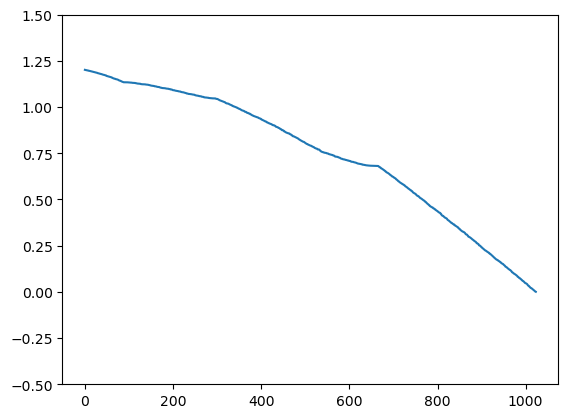

In [131]:
plt.plot(zeropower_via_newtonschulz5(G, steps=7, dtype=torch.float32).double().svd().S)
plt.ylim(-0.5, 1.5)
plt.show()

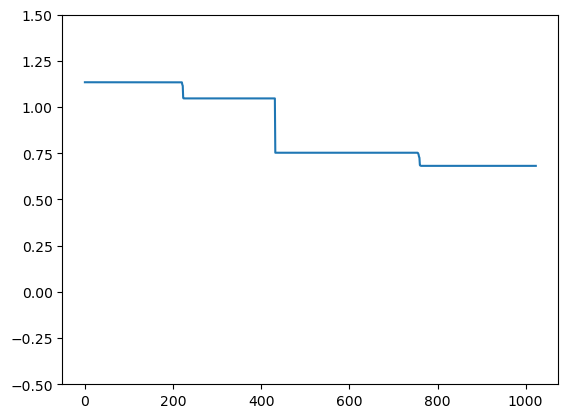

In [125]:
plt.plot(zeropower_via_newtonschulz5(G, steps=50, dtype=torch.float32).double().svd().S)
plt.ylim(-0.5, 1.5)
plt.show()

In [126]:
abcbad = torch.tensor((3.4445, -4.7750,  2.0315))
abcgood = torch.tensor((1.5, -0.5, 0))

In [146]:
def make_schedule(iter5, itermid, iter3):
    abcschedule = torch.cat([
        abcbad.expand(iter5, 3),
        torch.lerp(abcbad, abcgood, torch.linspace(0, 1, itermid + 2)[1:-1, None]),
        abcgood.expand(iter3, 3),
    ], 0)
    return abcschedule

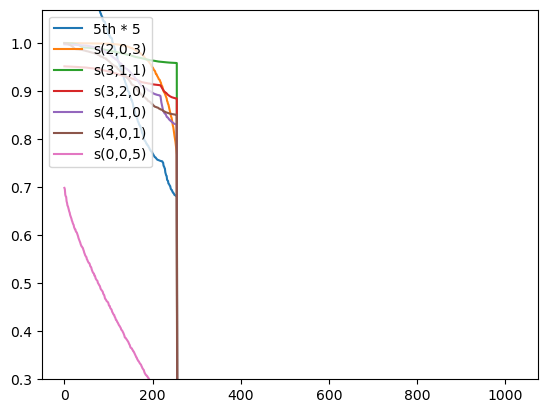

In [200]:
plt.plot(zeropower_via_newtonschulz5(G, steps=5, dtype=torch.float32).double().svd().S, label='5th * 5')
# plt.plot(zeropower_via_newtonschulz5(G, steps=8, dtype=torch.float32).double().svd().S, label='5th * 7')
# plt.plot(zeropower_via_newtonschulz5(G, steps=10, dtype=torch.float32).double().svd().S, label='5th * 10')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32).double().svd().S, label='5th * 13')
# plt.plot(zeropower_via_newtonschulz5(G, steps=14, dtype=torch.float32).double().svd().S, label='5th * 14')
# plt.plot(zeropower_via_newtonschulz5(G, steps=10, dtype=torch.float32, abc=make_schedule(6, 2, 2)).double().svd().S, label='s(6,2,2)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=10, dtype=torch.float32, abc=make_schedule(8, 0, 2)).double().svd().S, label='s(8,0,2)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=11, dtype=torch.float32, abc=make_schedule(9, 0, 2)).double().svd().S, label='s(9,0,2)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=11, dtype=torch.float32, abc=make_schedule(9, 1, 1)).double().svd().S, label='s(9,1,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=12, dtype=torch.float32, abc=make_schedule(8, 2, 2)).double().svd().S, label='s(8,2,2)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=12, dtype=torch.float32, abc=make_schedule(10, 0, 2)).double().svd().S, label='s(10,0,2)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32, abc=make_schedule(9, 1, 3)).double().svd().S, label='s(9,1,3)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32, abc=make_schedule(9, 2, 2)).double().svd().S, label='s(9,2,2)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32, abc=make_schedule(10, 0, 3)).double().svd().S, label='s(10,0,3)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=14, dtype=torch.float32, abc=make_schedule(10, 0, 4)).double().svd().S, label='s(10,0,4)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32, abc=make_schedule(10, 1, 2)).double().svd().S, label='s(10,1,2)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32, abc=make_schedule(10, 2, 1)).double().svd().S, label='s(10,2,1)')
plt.plot(zeropower_via_newtonschulz5(G, steps=5, dtype=torch.bfloat16, abc=make_schedule(2, 0, 3)).double().svd().S, label='s(2,0,3)')
plt.plot(zeropower_via_newtonschulz5(G, steps=5, dtype=torch.bfloat16, abc=make_schedule(3, 1, 1)).double().svd().S, label='s(3,1,1)')
plt.plot(zeropower_via_newtonschulz5(G, steps=5, dtype=torch.bfloat16, abc=make_schedule(3, 2, 0)).double().svd().S, label='s(3,2,0)')
plt.plot(zeropower_via_newtonschulz5(G, steps=5, dtype=torch.bfloat16, abc=make_schedule(4, 1, 0)).double().svd().S, label='s(4,1,0)')
plt.plot(zeropower_via_newtonschulz5(G, steps=5, dtype=torch.bfloat16, abc=make_schedule(4, 0, 1)).double().svd().S, label='s(4,0,1)')
plt.plot(zeropower_via_newtonschulz5(G, steps=5, dtype=torch.bfloat16, abc=make_schedule(0, 0, 5)).double().svd().S, label='s(0,0,5)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=7, dtype=torch.float32, abc=make_schedule(5, 2, 0)).double().svd().S, label='s(5,2,0)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=7, dtype=torch.float32, abc=make_schedule(4, 2, 1)).double().svd().S, label='s(4,2,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=8, dtype=torch.float32, abc=make_schedule(7, 1, 0)).double().svd().S, label='s(7,1,0)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=8, dtype=torch.float32, abc=make_schedule(7, 0, 1)).double().svd().S, label='s(7,0,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=10, dtype=torch.float32, abc=make_schedule(9, 0, 1)).double().svd().S, label='s(9,0,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=10, dtype=torch.float32, abc=make_schedule(8, 1, 1)).double().svd().S, label='s(8,1,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=10, dtype=torch.float32, abc=make_schedule(8, 2, 0)).double().svd().S, label='s(8,2,0)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=10, dtype=torch.float32, abc=make_schedule(7, 2, 1)).double().svd().S, label='s(7,2,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=14, dtype=torch.float32, abc=make_schedule(10, 4, 0)).double().svd().S, label='s(10,4,0)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=14, dtype=torch.float32, abc=make_schedule(10, 2, 2)).double().svd().S, label='s(10,2,2)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=14, dtype=torch.float32, abc=make_schedule(11, 3, 0)).double().svd().S, label='s(11,3,0)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=14, dtype=torch.float32, abc=make_schedule(11, 2, 1)).double().svd().S, label='s(11,2,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=14, dtype=torch.float32, abc=make_schedule(13, 0, 1)).double().svd().S, label='s(13,0,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=14, dtype=torch.float32, abc=make_schedule(12, 1, 1)).double().svd().S, label='s(12,1,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=14, dtype=torch.float32, abc=make_schedule(10, 1, 3)).double().svd().S, label='s(10,1,3)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32, abc=make_schedule(10, 3, 0)).double().svd().S, label='s(10,3,0)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32, abc=make_schedule(11, 0, 2)).double().svd().S, label='s(11,0,2)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32, abc=make_schedule(11, 1, 1)).double().svd().S, label='s(11,1,1)')
# plt.plot(zeropower_via_newtonschulz5(G, steps=13, dtype=torch.float32, abc=make_schedule(11, 2, 0)).double().svd().S, label='s(11,2,0)')
# plt.plot((
#     zeropower_via_newtonschulz5(
#         zeropower_via_newtonschulz5(G, steps=7, dtype=torch.float32),
#         steps=3,
#         dtype=torch.float32,
#         abc=abcgood,
#         normalize=False,
#     )
# ).double().svd().S, label='5th * 7, then 3rd * 3')
plt.legend(loc='upper left')
plt.ylim(-0, 1.2)
# plt.gca().set_xlim(920, 1050)
plt.gca().set_ylim(0.3, 1.07)

plt.show()


In [13]:
import sys
import importlib
if '241018_muon_renorm' in sys.modules:
    importlib.reload(sys.modules['241018_muon_renorm'])
OPTIM_MAP = __import__('241018_muon_renorm').OPTIM_MAP


In [16]:
lr_sm = [5e-5, 8e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 3e-3, 5e-3, 8e-3]
lr_lg = [1e-2, 3e-2, 5e-2, 8e-2, 1e-1, 3e-1, 5e-1, 8e-1, 1]
lrs = lr_sm + lr_lg

optims = sorted(OPTIM_MAP.keys())

print('''#! /bin/bash

set +e''')
for lr in lrs:
    for optim in optims:
        # if 'sign' not in optim:
        #     continue
        print(f"python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_rtx_6000_ada_generation nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb -e py312 {optim}_{lr:g} -- python 241018_muon_renorm.py {optim} {lr:g} 0")



#! /bin/bash

set +e
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_rtx_6000_ada_generation nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb -e py312 adam_5e-05 -- python 241018_muon_renorm.py adam 5e-05 0
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_rtx_6000_ada_generation nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb -e py312 adam_b095_5e-05 -- python 241018_muon_renorm.py adam_b095 5e-05 0
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_rtx_6000_ada_generation nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb -e py312 adam_b0995_5e-05 -- python 241018_muon_renorm.py adam_b0995 5e-05 0
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_rtx_6000_ada_generation nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb -e py312 m

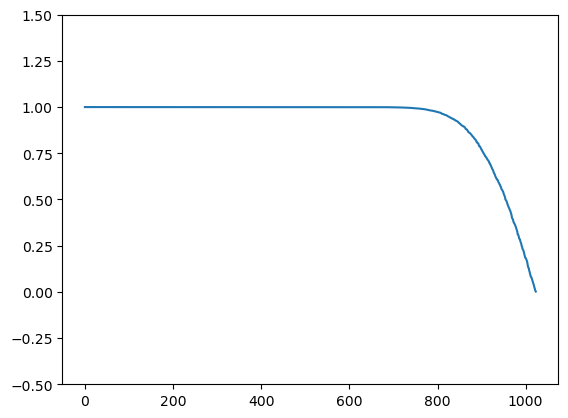

In [130]:
plt.plot(zeropower_via_newtonschulz5(G, steps=10, dtype=torch.float32, abc=abcschedule).svd().S)
plt.ylim(-0.5, 1.5)
plt.show()

In [124]:
plt.plot((
    zeropower_via_newtonschulz5(
        zeropower_via_newtonschulz5(G, steps=5, dtype=torch.float32),
        steps=5,
        dtype=torch.float32,
        abc=(1.5, -0.5, 0),
        normalize=False,
    )
).double().svd().S)
plt.ylim(-0.5, 1.5)
plt.show()

AttributeError: 'tuple' object has no attribute 'expand'

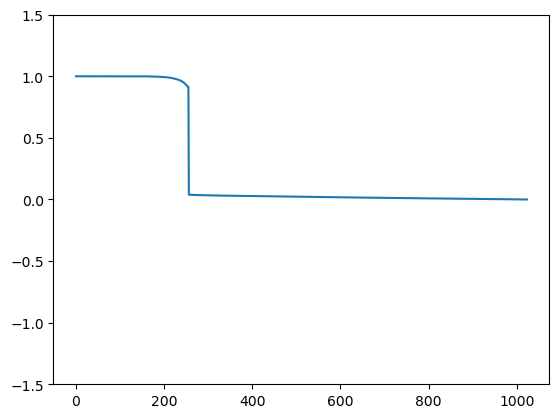

In [82]:
plt.plot(zeropower_via_newtonschulz5(G, dtype=torch.float32, abc=(1.5, -0.5, 0)).svd().S)
plt.ylim(-1.5, 1.5)
plt.show()

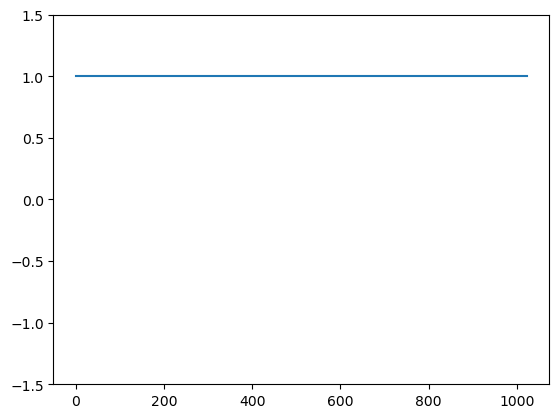

In [83]:
plt.plot(zeropower_via_newtonschulz5(G, steps=50, dtype=torch.float32, abc=(1.5, -0.5, 0)).svd().S)
plt.ylim(-1.5, 1.5)
plt.show()

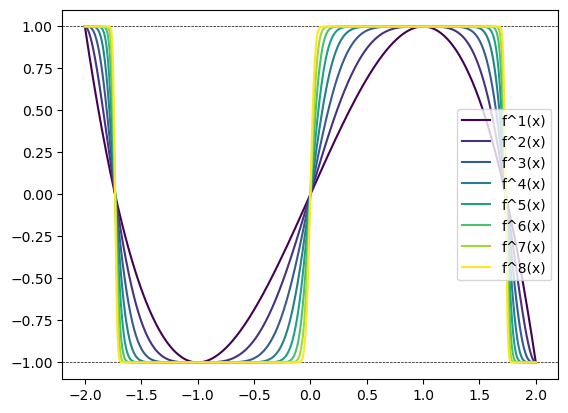

In [61]:
# plot f(x), f^2(x), f^3(x), f^4(x), f^5(x) over the interval [-2, 2]

def plot_f_powers(f, steps=10):
    # use color from viridis colormap
    colors = plt.cm.viridis(np.linspace(0, 1, steps))
    x = torch.linspace(-2, 2, 1000)
    y = x
    for i in range(steps):
        y = f(y)
        plt.plot(x, y, color=colors[i], label=f'f^{i+1}(x)')
    plt.axhline(-1, color='black', ls='--', linewidth=0.5, zorder=-1)
    plt.axhline(1, color='black', ls='--', linewidth=0.5, zorder=-1)
    plt.ylim(-1.1, 1.1)
    plt.legend()
    plt.show()

plot_f_powers(lambda x: 1.5 * x - 0.5 * x.pow(3), steps=8)

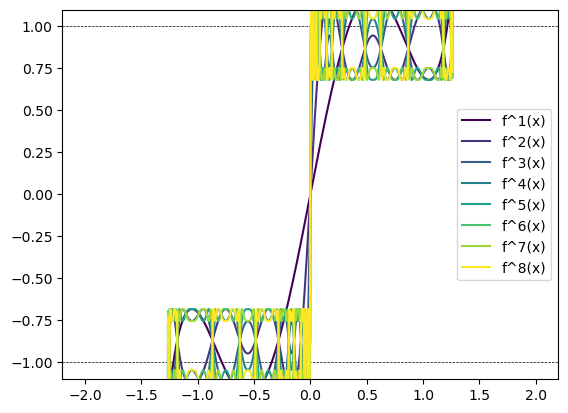

In [63]:
plot_f_powers(lambda x: 3.4445 * x -4.7750 * x.pow(3) + 2.0315 * x.pow(5), steps=8)